# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
#Refered/code-reusebility from ipynb from applied_ai_course notes 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.metrics import confusion_matrix
#from sklearn import metrics
#from sklearn.metrics import roc_curve, auc

# [1]. Reading Data

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId 
HAVING COUNT(*)>1
LIMIT 5000
""", con)

In [4]:
print(display.shape)
display.head(5)

(5000, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
WHERE UserId ='AZY10LLTJ71NX'
GROUP BY UserId 
HAVING COUNT(*)>1 
LIMIT 5000
""", con)
display.head()
#display[display['UserId']=='AZY10LLTJ71NX']


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()


(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [95]:
#Natural-Text-pre-processing 
#finding the which sentence contains html tags

import re

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;


0
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [15]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

stop = set(stopwords.words('english')) #set of stopwords

sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
sno.stem('delicious')
#stop


'delici'

In [16]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from tqdm import tqdm
import os

final_string=[] #creating a empty list for storing final preprocessed data
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
for i, sent in enumerate(tqdm(final['Text'].values)):
    filtered_sentence=[] #empty list for store after remove html and punc's and alfanumeric and words >2 and not in stop and converted to lowercase 
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)# above steps are stored here 
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews stored with above 
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews stored with above 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words stored in str1   
    final_string.append(str1) #here str1 stored in final_string
print("filtered sentences are stored successfully")


100%|█████████████████████████████████████| 4986/4986 [00:07<00:00, 667.63it/s]


filtered sentences are stored successfully


In [136]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
print("cleaned data is added successfully in cleaned text feature")
#final = final.drop(columns = "Text")
final.shape
final.head(10)
#final.CleanedText.values[:50]

cleaned data is added successfully in cleaned text feature


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product avail www amazon com victor trap unrea...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,use victor fli bait season cant beat great pro...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...,glad cocker standard poodl puppi love stuff tr...
2941,3203,B000084DVR,A3DKGXWUEP1AI2,"Glenna E. Bauer ""Puppy Mum""",3,3,1,1163030400,Premium Quality Dog Food!!!,We have been using this food for about 6 month...,use food month find excel fact two dog coton t...
1071,1161,B000084E1U,A3DH85EYHW4AQH,Eric Hochman,1,1,1,1140739200,Cats love it!,I have nine cats and they are crazy about thes...,nine cat crazi kibbl last thing want cat food ...
2187,2380,B0000CGFV4,A3LSUKN4IFS6VD,Internet Diva,0,0,1,1312416000,"Nice, Big Pieces & Big Almond Flavor",These were shipped out the day after I ordered...,ship day order arriv within day live opposit c...
4695,5097,B0000D94SZ,A2R91PG1XPNO0B,"Kotton Kandee ""not so secretshopper""",4,4,1,1184198400,"A Summer Treat Fat Free, Guilt Free",This mix is probably not something you would w...,mix probabl someth would want use everyday new...
2068,2256,B0000DC5IY,AGYZZ3QXV9S8,"Dr. Glenn B. Gero ""NJnaturaldoc""",3,4,0,1289865600,Don't buy this product unless you are looking ...,The description of this product is disceptive....,descript product discept product repres powder...


In [18]:
#Random reviews after text pre-processing 
final.CleanedText[20]
final.CleanedText[500]
final.CleanedText[90]

'fed golden retriev hate wouldnt eat gave terribl diarrhea buy also super expens'

In [146]:
#all the filtered sentences and positive and negative reviews with bytes foramt for faster processing 
# are stored in final_string
#Now most common positive words and negitive words

freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words in review : ",freq_dist_positive.most_common(20))
print('-' *100)
print("Most Common Negative Words in review: ",freq_dist_negative.most_common(20))

Most Common Positive Words in review :  [(b'like', 1812), (b'tast', 1636), (b'good', 1571), (b'flavor', 1549), (b'love', 1468), (b'great', 1442), (b'use', 1269), (b'product', 1204), (b'one', 1193), (b'tri', 1161), (b'coffe', 1027), (b'food', 1017), (b'chip', 997), (b'make', 982), (b'get', 830), (b'tea', 801), (b'bag', 761), (b'buy', 728), (b'best', 710), (b'eat', 709)]
----------------------------------------------------------------------------------------------------
Most Common Negative Words in review:  [(b'like', 444), (b'tast', 432), (b'product', 399), (b'tri', 282), (b'one', 281), (b'flavor', 271), (b'would', 247), (b'food', 241), (b'use', 231), (b'good', 207), (b'buy', 187), (b'order', 185), (b'tea', 182), (b'chip', 180), (b'bag', 179), (b'get', 179), (b'even', 169), (b'make', 162), (b'box', 161), (b'mix', 155)]


<h2><font color='red'>[3.2] Preprocess Summary Text</font></h2>

In [161]:
#finding html tags in summary text 

j=0;
for summary in final['Summary'].values:
    if (len(re.findall('<.*?>', summary))):
        print(j)
        print(summary)
    else:
        print("There is no html tags")
        print('-'*50)
        break;
    j += 1;
final["Summary"].head(10)

There is no html tags
--------------------------------------------------


2546                                        thirty bucks?
2547                                         Flies Begone
1145                       WOW Make your own 'slickers' !
1146                                        Great Product
2942                                          Good stuff!
2941                          Premium Quality Dog Food!!!
1071                                        Cats love it!
2187                 Nice, Big Pieces & Big Almond Flavor
4695                  A Summer Treat Fat Free, Guilt Free
2068    Don't buy this product unless you are looking ...
Name: Summary, dtype: object

In [158]:
#removing if any html tags and punctuations in summary feature
#observed there is no html tags in summary attribute 

#def cleanhtml(s_sentence): #function to clean the word of any html-tags
#    s_cleanr = re.compile('<.*?>')
#    s_cleantext = re.sub(s_cleanr, ' ', s_sentence)
#    return s_cleantext

def cleanpunc(s_sentence): #function to clean the word of any punctuation or special characters
    s_cleaned = re.sub(r'[?|!|\'|"|#]',r'',s_sentence)
    s_cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',s_cleaned)
    return  s_cleaned

s_stop = set(stopwords.words('english')) #set of stopwords

s_sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
s_sno.stem('wow')

'wow'

In [160]:
summary_final_string=[] #creating a empty list for storing final preprocessed data
summary_all_positive_words=[] # store words from +ve summary here
summary_all_negative_words=[] # store words from -ve summary here.
for j, summary_sent in enumerate(tqdm(final['Summary'].values)):
    summary_filtered_sentence=[] #empty list for store after remove  punc's and alphanumeric and words >2 and not in stop and converted to lowercase 
    #summary_sent=cleanhtml(summary_sent) # remove HTMl tags
    for s_w in summary_sent.split():
        for s_cleaned_words in cleanpunc(s_w).split():
            if((s_cleaned_words.isalpha()) & (len(s_cleaned_words)>2)):    
                if(s_cleaned_words.lower() not in s_stop):
                    s_s=(s_sno.stem(s_cleaned_words.lower())).encode('utf8')
                    summary_filtered_sentence.append(s_s)# above steps are stored here 
                    if (final['Score'].values)[j] == 1: 
                        summary_all_positive_words.append(s_s) #list of all words used to describe positive summary stored with above 
                    if(final['Score'].values)[j] == 0:
                        summary_all_negative_words.append(s_s) #list of all words used to describe negative summary reviews stored with above 
    s_str1 = b" ".join(summary_filtered_sentence) #final string of cleaned words stored in s_str1   
    summary_final_string.append(s_str1) #here s_str1 stored in summary_final_string
print("filtered summary are stored successfully in summary_final_string")
len(summary_final_string)

100%|████████████████████████████████████| 4986/4986 [00:00<00:00, 8645.95it/s]


filtered summary are stored successfully in summary_final_string


4986

In [163]:
s_freq_dist_positive=nltk.FreqDist(summary_all_positive_words)
s_freq_dist_negative=nltk.FreqDist(summary_all_negative_words)
print("Most Common Positive Words in summary : ",s_freq_dist_positive.most_common(20))
print('-' *100)
print("Most Common Negative Words in summary : ",s_freq_dist_negative.most_common(20))

Most Common Positive Words in summary :  [(b'great', 691), (b'good', 439), (b'best', 366), (b'love', 309), (b'tast', 201), (b'delici', 173), (b'chip', 162), (b'dog', 155), (b'product', 151), (b'coffe', 143), (b'tea', 131), (b'excel', 131), (b'food', 128), (b'yummi', 124), (b'hot', 106), (b'flavor', 104), (b'ever', 93), (b'tasti', 91), (b'snack', 82), (b'price', 81)]
----------------------------------------------------------------------------------------------------
Most Common Negative Words in summary :  [(b'tast', 65), (b'good', 45), (b'like', 32), (b'product', 27), (b'flavor', 25), (b'disappoint', 23), (b'dont', 22), (b'chip', 21), (b'bad', 19), (b'aw', 18), (b'poor', 17), (b'food', 16), (b'price', 16), (b'worst', 15), (b'ever', 15), (b'much', 15), (b'buy', 14), (b'money', 14), (b'wast', 13), (b'tea', 13)]


In [172]:
final['Cleanedsummary']=summary_final_string
final[0:1]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleanedsummary
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product avail www amazon com victor trap unrea...,b'thirti buck'


# [4] Featurization

## [4.1] BAG OF WORDS

In [60]:
#APPLYING_BOW
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])
bow=final_counts.todense()
print('-' * 50 )
print("here below  we converting scipy to dense for tsne ")
print('-' * 50 )
print("the type of count vectorizer ",type(bow))

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 8574)
the number of unique words  8574
--------------------------------------------------
here below  we converting scipy to dense for tsne 
--------------------------------------------------
the type of count vectorizer  <class 'numpy.matrixlib.defmatrix.matrix'>


## [4.2] Bi-Grams and n-Grams.

In [59]:
#UNI_GRAMS-BI_GRAMS-TRI_GRAMS
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn range will choose how many grams we want here we choose 1 and 2 means uni and bi and n it will be tri and so..onnn 
final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])
bi_gram=final_bigram_counts.todense()
print('-' * 50 )
print("here below  we converting scipy to dense for tsne ")
print('-' * 50 )
print("the type of count vectorizer ",type(bi_gram))

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 122642)
the number of unique words including both unigrams and bigrams  122642
--------------------------------------------------
here below  we converting scipy to dense for tsne 
--------------------------------------------------
the type of count vectorizer  <class 'numpy.matrixlib.defmatrix.matrix'>


## [4.3] TF-IDF

In [58]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])
tfidf=final_tf_idf.todense()
print('-' * 50 )
print("here below  we converting scipy to dense for tsne ")
print('-' * 50 )
print("the type of count vectorizer ",type(tfidf))


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 122642)
the number of unique words including both unigrams and bigrams  122642
--------------------------------------------------
here below  we converting scipy to dense for tsne 
--------------------------------------------------
the type of count vectorizer  <class 'numpy.matrixlib.defmatrix.matrix'>


## [4.4] Word2Vec

In [24]:
# Train your own Word2Vec model using your own text corpus
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

cleantext= final['CleanedText'] # building own text corpus from dataset 
i=0
list_of_sentance=[]
for sentance in cleantext:
    list_of_sentance.append(sentance.split())

In [25]:
#WORD2VEC USING OWN CORPUS
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_model.wv.most_similar('like')   

[('tast', 0.9865828156471252),
 ('strong', 0.9858685731887817),
 ('bitter', 0.9816362857818604),
 ('sweet', 0.9813024401664734),
 ('flavor', 0.9760134220123291),
 ('realli', 0.9752798676490784),
 ('cream', 0.9752498865127563),
 ('dark', 0.9715099334716797),
 ('light', 0.9678508639335632),
 ('pepper', 0.9663236737251282)]

In [26]:
w2v_model.wv.most_similar('bad')

[('say', 0.9984477758407593),
 ('care', 0.9979042410850525),
 ('wrong', 0.9978870749473572),
 ('cours', 0.9977049827575684),
 ('crave', 0.9976991415023804),
 ('although', 0.9976569414138794),
 ('suppos', 0.997613787651062),
 ('fact', 0.9975495934486389),
 ('addict', 0.9974206686019897),
 ('either', 0.9974170923233032)]

In [27]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words from corpus  ", w2v_words[0:50])

number of words that occured minimum 5 times  2955
sample words from corpus   ['product', 'avail', 'www', 'amazon', 'com', 'trap', 'cours', 'total', 'fli', 'pretti', 'stinki', 'right', 'nearbi', 'use', 'season', 'cant', 'beat', 'great', 'receiv', 'shipment', 'could', 'hard', 'wait', 'tri', 'love', 'call', 'instead', 'sticker', 'remov', 'easili', 'daughter', 'design', 'sign', 'print', 'car', 'window', 'beauti', 'shop', 'program', 'go', 'lot', 'fun', 'everywher', 'like', 'screen', 'comput', 'monitor', 'realli', 'good', 'idea']


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [28]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
print(type(sent_vectors))

100%|████████████████████████████████████| 4986/4986 [00:04<00:00, 1205.50it/s]


4986
50
<class 'list'>


#### [4.4.1.2] TFIDF weighted W2v

In [29]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(final['CleanedText'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [65]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
             #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
print(len(sent_vec))
print(len(tfidf_sent_vectors))  
print(type(tfidf_sent_vectors))  

100%|█████████████████████████████████████| 4986/4986 [00:21<00:00, 231.37it/s]


50
4986
<class 'list'>


# [5] Applying TSNE

<ol> 
    <li> you need to plot 4 tsne plots with each of these feature set
        <ol>
            <li>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ol>
    </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points </font></li>
</ol>

## [5.1] Applying TNSE on Text BOW vectors

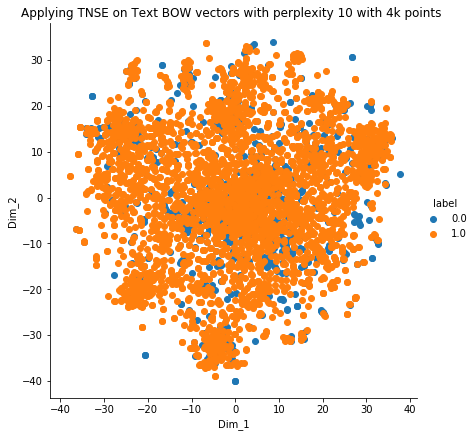

In [31]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

#Refer-link https://github.com/DmitryUlyanov/Multicore-TSNE

from MulticoreTSNE import MulticoreTSNE as MultiTSNE
import seaborn as sn

sample_score = final['Score'][:4000]
sample_bow = bow[:4000]
#sample_bi_gram = bi_gram

multi_tsne = MultiTSNE(n_components=2,n_jobs=1, random_state=0,perplexity= 10,n_iter=5000) 

multi_model = multi_tsne.fit_transform(sample_bow)

multi_model = np.vstack((multi_model.T, sample_score)).T
tsne_df = pd.DataFrame(data = multi_model, columns=("Dim_1", "Dim_2", "label"))

#Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("Applying TNSE on Text BOW vectors with perplexity 10 with 4k points ")
plt.show()


# OBSERVATION 

After multiple executions the observed point is there is higher number of positive reviews and lesser number of negitive reviews ,So when applying TSNE all positive reviews overlaped with negitive reviews So identification is clear in by taking of small sample TSNE gives better visualisation compare to large sample.

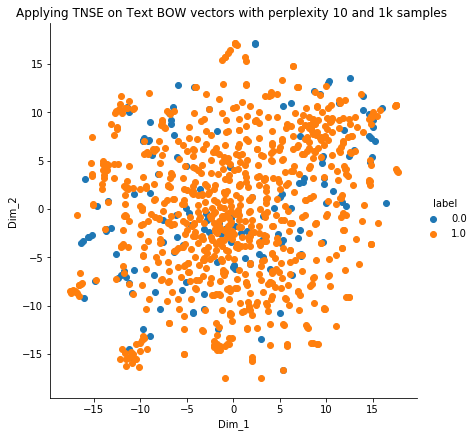

In [32]:
sample_score = final['Score'][:1000]
sample_bow = bow[:1000]
#sample_bi_gram = bi_gram

multi_tsne = MultiTSNE(n_components=2,n_jobs=1, random_state=0,perplexity= 10,n_iter=1500) 

multi_model = multi_tsne.fit_transform(sample_bow)

multi_model = np.vstack((multi_model.T, sample_score)).T
tsne_df = pd.DataFrame(data = multi_model, columns=("Dim_1", "Dim_2", "label"))

#Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("Applying TNSE on Text BOW vectors with perplexity 10 and 1k samples ")
plt.show()

# OBSERVATION 
By taking small samples it will gives better visualisation taking higher 10 perplexity value will giving more dense points 

## [5.1] Applying TNSE on Text TFIDF vectors

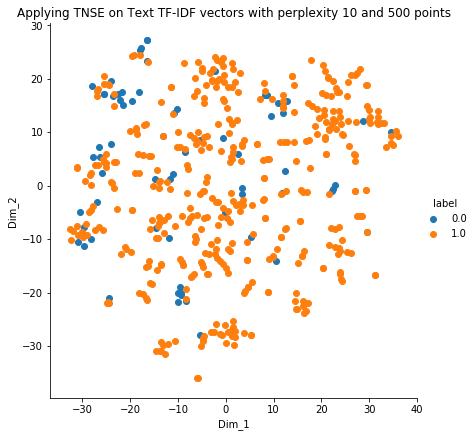

In [34]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
sample_score = final['Score'][:500]

sample_tf_idf = tfidf[:500]

multi_tsne = MultiTSNE(n_components=2,n_jobs=4, random_state=0,perplexity= 10) 

multi_model = multi_tsne.fit_transform(sample_tf_idf)

multi_model = np.vstack((multi_model.T, sample_score)).T
tsne_df = pd.DataFrame(data = multi_model, columns=("Dim_1", "Dim_2", "label"))

#Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("Applying TNSE on Text TF-IDF vectors with perplexity 10 and 500 points")
plt.show()

# OBSERVATION ON TF_IDF 
Observed unidentified activity that is taking more than 700 points from tfidf_sample  only system will freezes ,So observed in 700 points some of negitive words are closer to positive words in tf-idf and most of the words from  postive reviews 

## [5.3] Applying TNSE on Text Avg W2V vectors

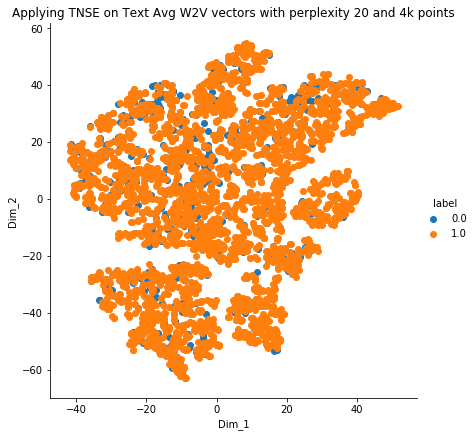

In [41]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
sample_score = final['Score'][:4000]
sample_avgw2v = sent_vectors[:4000]

avgw2v_array_sample = np.asarray(sample_avgw2v)

# list did't support to visualize with multi-tsne so converted to array

multi_tsne = MultiTSNE(n_components=2,n_jobs=4, random_state=0,perplexity= 20,n_iter=2000) 

multi_model = multi_tsne.fit_transform(avgw2v_array_sample)

multi_model = np.vstack((multi_model.T, sample_score)).T
tsne_df = pd.DataFrame(data = multi_model, columns=("Dim_1", "Dim_2", "label"))

#Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("Applying TNSE on Text Avg W2V vectors with perplexity 20 and 4k points")
plt.show()


# OBSERVATION IN TNSE on Text Avg W2V vectors
Almost all the positive and negitive are overlapped but get a different structure because most of postivie reviews are high compare to negitive 

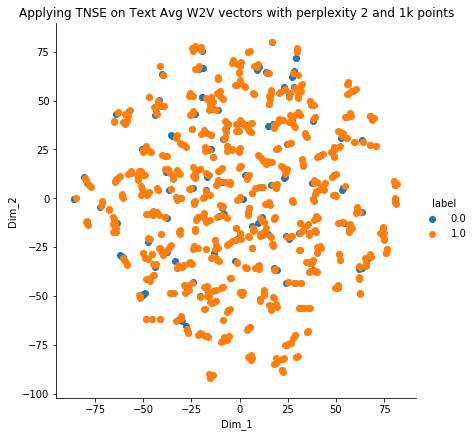

In [95]:
sample_score = final['Score'][:1000]
sample_avgw2v = sent_vectors[:1000]
avgw2v_array_sample = np.asarray(sample_avgw2v)

# list did't support to visualize with multi-tsne so converted to array

multi_tsne = MultiTSNE(n_components=2,n_jobs=4, random_state=0,perplexity= 2,n_iter=1500) 

multi_model = multi_tsne.fit_transform(avgw2v_array_sample)

multi_model = np.vstack((multi_model.T, sample_score)).T
tsne_df = pd.DataFrame(data = multi_model, columns=("Dim_1", "Dim_2", "label"))

#Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("Applying TNSE on Text Avg W2V vectors with perplexity 2 and 1k points")
plt.show()

# OBSERVATION
Here we observe that most of the negitive words are closer to positive might be same meaning or vice-versa and both are mostly overlapped 

## [5.4] Applying TNSE on Text TFIDF weighted W2V vectors

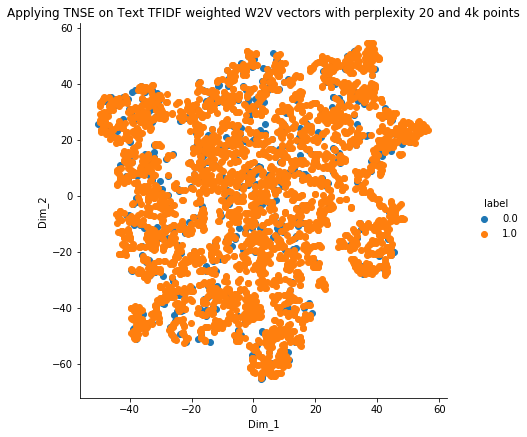

In [101]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
sample_score = final['Score'][:4000]
sample_tfidf_w2v = tfidf_sent_vectors[:4000]

sample_array_tfidf_w2v = np.asarray(sample_tfidf_w2v)

multi_tsne = MultiTSNE(n_components=2,n_jobs=4, random_state=0,perplexity= 20,n_iter=5000) 
multi_model = multi_tsne.fit_transform(sample_array_tfidf_w2v)
multi_model = np.vstack((multi_model.T, sample_score)).T
tsne_df = pd.DataFrame(data = multi_model, columns=("Dim_1", "Dim_2", "label"))

#Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("Applying TNSE on Text TFIDF weighted W2V vectors with perplexity 20 and 4k points")
plt.show()

# OBSERVATION:
    Here in this also getting same both positive and negative are fully overlapped or becasue of less number negitive reviews / words and getting similar structure with avgw2v 

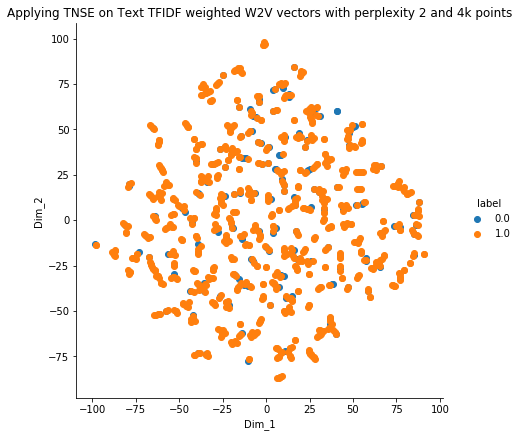

In [102]:
sample_score = final['Score'][:1000]
sample_tfidf_w2v = tfidf_sent_vectors[:1000]

sample_array_tfidf_w2v = np.asarray(sample_tfidf_w2v)

multi_tsne = MultiTSNE(n_components=2,n_jobs=4, random_state=0,perplexity= 2,n_iter=1500) 
multi_model = multi_tsne.fit_transform(sample_array_tfidf_w2v)
multi_model = np.vstack((multi_model.T, sample_score)).T
tsne_df = pd.DataFrame(data = multi_model, columns=("Dim_1", "Dim_2", "label"))

#Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("Applying TNSE on Text TFIDF weighted W2V vectors with perplexity 2 and 4k points")
plt.show()

# OBSERVATION
Here is the small sample of tfidf weighted are also most of the negitive reviews/words are overlapped with some positive reviews/words by small sample view  getting similar structure with avgw2v small sample view

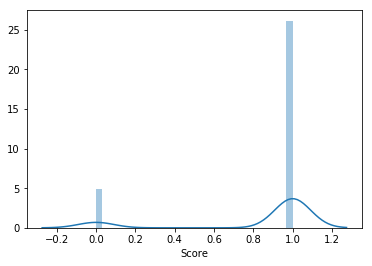

In [103]:
sns.distplot(sample_score)

# [6] Conclusions


Here by done above analysis we conclude that most of the words/reviews are positive and lesser are negitive ,

if we check that dataset is imbalance by seeing above sample sns.distplot will gives some sample information ,

most of negitive words/reviews are lie inside of positive reviews/revies or may be some customers gave positive review or negitive review for same product with different types from a same seller , 

so here reviews might be done for different products from single seller  with different types ,

Most of the negitive reviews are lesser than positive reviews that is reason for above tsne
plots are overlapped. 
